In [1]:
import pandas as pd
import mediapipe as mp
from PIL import Image
from pathlib import Path
import numpy as np

In [3]:
import glob

images = glob.glob('./모은이미지/구도_C2/*.jpg')
len(images)

2320

In [4]:
from IPython.display import Image, display
import cv2

def img_show(image, width=400):
    _, buffer = cv2.imencode('.jpg', image)
    display(Image(data=buffer.tobytes(), width=width))

In [5]:
def extract_landmarks_from_image(image):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

    results = pose.process(image)

    return results

In [6]:
images[50]

'./모은이미지/구도_C2\\00034_H_A_SY_C2_00034_H_A_SY_C2_I001.jpg'

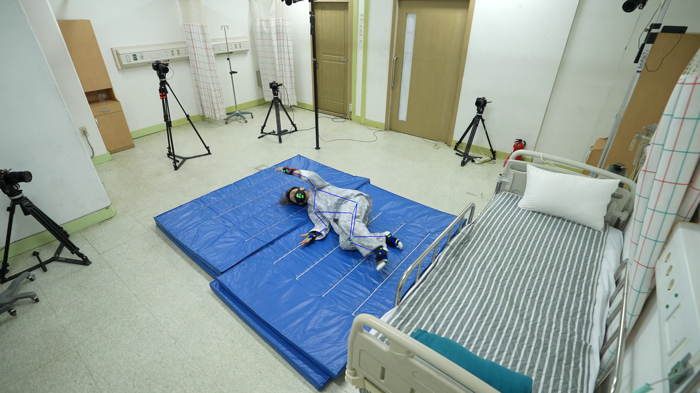

landmarks shape: (33, 4)


In [14]:
from pathlib import Path
from PIL import Image
import numpy as np
import mediapipe as mp
from IPython.display import display

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def show_skeleton_on_image(img_path, viz_width=700):
    p = Path(img_path)
    if not p.exists():
        raise FileNotFoundError(f"파일이 없습니다: {p.resolve()}")
    # 안전하게 읽기 (한글/공백 경로에 안전)
    img_pil = Image.open(p).convert("RGB")
    arr = np.array(img_pil)  # RGB
    h, w = arr.shape[:2]

    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        results = pose.process(arr)

    annotated = arr.copy()
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            annotated,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
        )

    # resize for display while preserving aspect ratio
    scale = viz_width / w if w > viz_width else 1.0
    disp_img = Image.fromarray(annotated)
    if scale != 1.0:
        disp_img = disp_img.resize((int(w*scale), int(h*scale)))

    display(disp_img)

    # return normalized landmarks as numpy array (N,4) or None
    if results.pose_landmarks:
        lms = np.array([[lm.x, lm.y, lm.z, getattr(lm, "visibility", np.nan)]
                        for lm in results.pose_landmarks.landmark], dtype=np.float32)
    else:
        lms = None
    return lms


img_path = images[55]
landmarks = show_skeleton_on_image(img_path)
print("landmarks shape:", None if landmarks is None else landmarks.shape)

In [15]:
import os
import numpy as np
import mediapipe as mp
from pathlib import Path
from PIL import Image

# ==========================================
# 1. 설정 및 경로 지정
# ==========================================
# 원본 이미지가 있는 폴더 경로
INPUT_DIR = Path(r"C:\Users\ASUS\Desktop\딥러닝 프로젝트\모은이미지\구도_C2")

# 결과 이미지를 저장할 폴더 경로 (원본 폴더 옆에 생성됨)
# 예: ...\딥러닝 프로젝트\이미지_스켈레톤
OUTPUT_DIR = INPUT_DIR.parent / "이미지_스켈레톤"

# 저장 폴더가 없으면 생성
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Mediapipe 설정
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

print(f"입력 폴더: {INPUT_DIR}")
print(f"출력 폴더: {OUTPUT_DIR}")

# ==========================================
# 2. 이미지 처리 및 저장 루프
# ==========================================
def process_batch_images():
    # 지원할 이미지 확장자
    valid_extensions = {'.jpg'}
    
    # 이미지 파일 리스트 가져오기
    image_files = [p for p in INPUT_DIR.glob("*") if p.suffix.lower() in valid_extensions]
    
    if not image_files:
        print("폴더에 이미지 파일이 없습니다.")
        return

    print(f"총 {len(image_files)}개의 이미지를 처리합니다...")

    # Pose 모델을 루프 밖에서 한 번만 로드 (속도 향상 핵심)
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        
        for idx, img_path in enumerate(image_files):
            try:
                # 1. 이미지 읽기 (PIL 사용으로 한글 경로 안전하게 처리)
                img_pil = Image.open(img_path).convert("RGB")
                arr = np.array(img_pil)
                
                # 2. 스켈레톤 추론
                results = pose.process(arr)
                
                # 3. 그리기 (복사본에 그리기)
                annotated = arr.copy()
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(
                        annotated,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2), # 관절 점 (초록)
                        mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)  # 뼈대 선 (파랑) -> 필요시 색상 변경
                    )
                else:
                    print(f"[Skip] 사람 미검출: {img_path.name}")
                    # 사람이 없어도 원본이라도 저장하고 싶으면 아래 continue를 지우세요
                    # continue 

                # 4. 저장하기
                # 결과 이미지를 PIL 객체로 변환
                result_pil = Image.fromarray(annotated)
                
                # 저장 경로 생성
                save_path = OUTPUT_DIR / img_path.name
                
                # 파일 저장
                result_pil.save(save_path)
                
                # 진행 상황 출력 (10장마다)
                if (idx + 1) % 10 == 0:
                    print(f"진행 중... ({idx + 1}/{len(image_files)})")

            except Exception as e:
                print(f"에러 발생 ({img_path.name}): {e}")

    print("\n 모든 작업이 완료되었습니다!")
    print(f"저장 위치: {OUTPUT_DIR.resolve()}")

# ==========================================
# 3. 실행
# ==========================================
if __name__ == "__main__":
    process_batch_images()

입력 폴더: C:\Users\ASUS\Desktop\딥러닝 프로젝트\모은이미지\구도_C2
출력 폴더: C:\Users\ASUS\Desktop\딥러닝 프로젝트\모은이미지\이미지_스켈레톤
총 2320개의 이미지를 처리합니다...
[Skip] 사람 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I006.jpg
[Skip] 사람 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I007.jpg
[Skip] 사람 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I008.jpg
[Skip] 사람 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I009.jpg
진행 중... (10/2320)
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I005.jpg
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I006.jpg
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I007.jpg
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I008.jpg
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I009.jpg
[Skip] 사람 미검출: 00008_H_A_SY_C2_00008_H_A_SY_C2_I010.jpg
진행 중... (20/2320)
[Skip] 사람 미검출: 00012_H_A_SY_C2_00012_H_A_SY_C2_I005.jpg
[Skip] 사람 미검출: 00012_H_A_SY_C2_00012_H_A_SY_C2_I006.jpg
[Skip] 사람 미검출: 00012_H_A_SY_C2_00012_H_A_SY_C2_I007.jpg
진행 중... (30/2320)
[Skip] 사람 미검출: 00018_H_A_SY_C2_00018_H_A_SY_C2_I006.jpg
[Skip] 사람 미검출: 00018_H_A_SY_C2_00018

In [ ]:
import cv2
import mediapipe as mp
from pathlib import Path

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def save_overlay_image(src, out_dir=None, out_name=None, model_complexity=1, target_width=None):
    """
    로컬 환경에서 이미지에 스켈레톤을 그리고 저장/출력하는 함수
    """
    src = Path(src)
    
    # 1. 파일 존재 여부 확인
    if not src.exists():
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {src}")

    # 2. 저장 경로 설정 (사용자가 원래 원했던 경로 로직 복원)
    # 별도로 지정하지 않으면 소스 파일이 있는 폴더 내 'result' 폴더에 저장
    if out_dir is None:
        # 혹은 원래 원하셨던 특정 절대 경로를 넣으셔도 됩니다.
        # default_out = Path(r"C:\Users\ASUS\Desktop\딥러닝 프로젝트\관절이미지") 
        default_out = src.parent / "result"
        out_dir = default_out
    else:
        out_dir = Path(out_dir)
        
    out_dir.mkdir(parents=True, exist_ok=True)

    if out_name is None:
        out_name = f"{src.stem}_skeleton.jpg"
    out_path = out_dir / out_name

    # 3. 이미지 읽기
    # 한글 경로가 포함된 경우 cv2.imread가 실패할 수 있어 numpy로 우회하여 읽는 방식 권장
    import numpy as np
    stream = open(str(src), "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    img = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    
    if img is None:
        raise ValueError(f"이미지를 읽을 수 없습니다. 경로를 확인하세요: {src}")

    h, w, _ = img.shape

    # 4. 리사이징 (선택 사항)
    if target_width and w > target_width:
        scale = target_width / w
        new_w = int(w * scale)
        new_h = int(h * scale)
        img = cv2.resize(img, (new_w, new_h))
    
    # 5. MediaPipe Pose 적용 (정적 이미지 모드)
    with mp_pose.Pose(
        static_image_mode=True, 
        model_complexity=model_complexity,
        min_detection_confidence=0.5) as pose:

        # BGR -> RGB 변환
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 추론 수행
        results = pose.process(rgb)

        # 6. 랜드마크 그리기
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                img, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
            )
            print("스켈레톤 추출 성공")
        else:
            print("스켈레톤을 찾지 못했습니다.")

    # 7. 이미지 저장 (한글 경로 대응을 위해 cv2.imencode 사용)
    extension = out_path.suffix
    result, encoded_img = cv2.imencode(extension, img)
    if result:
        with open(str(out_path), mode='w+b') as f:
            encoded_img.tofile(f)
        print(f"저장 완료: {out_path}")
    
    # 8. 로컬 창 띄우기 (Colab과 다른 부분)
    cv2.imshow("Skeleton Result", img)
    print("이미지 창을 닫으려면 아무 키나 누르세요.")
    cv2.waitKey(0)  # 키 입력 대기 (이게 없으면 창이 바로 꺼짐)
    cv2.destroyAllWindows()
    
    return out_path

In [17]:
image_file = images[55] 

try:
    save_overlay_image(image_file, target_width=800)
except Exception as e:
    print("에러:", e)

✅ 스켈레톤 추출 성공!
📁 저장 완료: 모은이미지\구도_C2\result\00034_H_A_SY_C2_00034_H_A_SY_C2_I006_skeleton.jpg
이미지 창을 닫으려면 아무 키나 누르세요.


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from pathlib import Path
import os

# 1. 저장할 폴더 설정 (없으면 자동 생성)
save_folder = Path("이미지_스켈레톤")
save_folder.mkdir(parents=True, exist_ok=True)

print(f"결과가 저장될 폴더: {save_folder.absolute()}")

# 2. MediaPipe 설정
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 스타일 설정 (관절: 초록, 선: 빨강)
landmark_style = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
connection_style = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)

# 3. 일괄 처리 시작
# Pose 모델을 루프 밖에서 한 번만 로드하여 속도를 높입니다.
with mp_pose.Pose(
    static_image_mode=True,       # 이미지 모드 (정확도 향상)
    model_complexity=1,           # 0, 1, 2 중 선택 (1이 밸런스 좋음)
    min_detection_confidence=0.5
) as pose:

    success_count = 0
    fail_count = 0

    print(f"총 {len(images)}장의 이미지 처리를 시작합니다...\n")

    for i, img_path in enumerate(images):
        path_obj = Path(img_path)
        
        # 파일명 유지하여 저장 경로 생성
        save_path = save_folder / f"skeleton_{path_obj.name}"
        
        try:
            # [읽기] 한글 경로 호환 코드
            # np.fromfile로 바이너리를 읽은 후 decode 해야 한글 경로 에러가 안 납니다.
            stream = open(str(path_obj), "rb")
            bytes = bytearray(stream.read())
            numpyarray = np.asarray(bytes, dtype=np.uint8)
            img = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
            stream.close() # 파일 닫기

            if img is None:
                print(f"[{i+1}/{len(images)}] 읽기 실패 (파일 손상 등): {path_obj.name}")
                fail_count += 1
                continue

            # [전처리] BGR -> RGB
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # [추론] 스켈레톤 추출
            results = pose.process(rgb_img)

            # [그리기] 결과가 있으면 원본 이미지 위에 그림
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    img,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_style,
                    connection_style
                )
                
                # [저장] 한글 경로 호환 코드
                # cv2.imwrite 대신 imencode 후 tofile 사용
                extension = path_obj.suffix # .jpg, .png 등
                result, encoded_img = cv2.imencode(extension, img)
                
                if result:
                    with open(str(save_path), mode='w+b') as f:
                        encoded_img.tofile(f)
                    print(f"[{i+1}/{len(images)}] 저장 완료: {save_path.name}")
                    success_count += 1
                else:
                    print(f"[{i+1}/{len(images)}] 인코딩 실패: {path_obj.name}")
                    fail_count += 1
            else:
                print(f"[{i+1}/{len(images)}] 스켈레톤 미검출: {path_obj.name}")
                # 스켈레톤이 없어도 원본을 저장하고 싶다면 아래 주석을 해제하세요.
                # cv2.imwrite(str(save_path), img) 
                fail_count += 1

        except Exception as e:
            print(f"[{i+1}/{len(images)}] 에러 발생 ({path_obj.name}): {e}")
            fail_count += 1

print("\n" + "="*50)
print(f"처리 완료")
print(f"성공: {success_count}장")
print(f"실패/미검출: {fail_count}장")
print(f"저장 위치: {save_folder.absolute()}")
print("="*50)

📂 결과가 저장될 폴더: c:\Users\ASUS\Desktop\딥러닝 프로젝트\이미지_스켈레톤
🚀 총 2320장의 이미지 처리를 시작합니다...

[1/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I001.jpg
[2/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I002.jpg
[3/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I003.jpg
[4/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I004.jpg
[5/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I005.jpg
[6/2320] ⚠️ 스켈레톤 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I006.jpg
[7/2320] ⚠️ 스켈레톤 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I007.jpg
[8/2320] ⚠️ 스켈레톤 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I008.jpg
[9/2320] ⚠️ 스켈레톤 미검출: 00004_H_A_SY_C2_00004_H_A_SY_C2_I009.jpg
[10/2320] ✅ 저장 완료: skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I010.jpg
[11/2320] ✅ 저장 완료: skeleton_00008_H_A_SY_C2_00008_H_A_SY_C2_I001.jpg
[12/2320] ✅ 저장 완료: skeleton_00008_H_A_SY_C2_00008_H_A_SY_C2_I002.jpg
[13/2320] ✅ 저장 완료: skeleton_00008_H_A_SY_C2_00008_H_A_SY_C2_I003.jpg
[14/2320] ✅ 저장 완료: skeleton_00008_H_A_SY_C2_00008

In [13]:
# 이미지에서 추출할 좌표 변수 입력

# 어깨
shoulder_left = 11
shoulder_right = 12
# 팔꿈치
elbow_left = 13
elbow_right = 14
# 손목
wrist_left = 15
wrist_right = 16

# 엉덩이
hip_left = 23
hip_right = 24
# 무릎
knee_left = 25
knee_right = 26
# 발목
ankle_left = 27
ankle_right = 28
# 발뒤꿈치
heel_left = 29
heel_right = 30
# 발가락
toe_left = 31
toe_right = 32

In [14]:
images = glob.glob('./이미지_스켈레톤_낙상/*.jpg')
len(images)

474

In [15]:
import mediapipe as mp
from PIL import Image
from pathlib import Path
import numpy as np

# Mediapipe 초기화
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [54]:
# 추출할 관절 인덱스 리스트
JOINT_INDICES = [
    shoulder_left, shoulder_right,
    elbow_left, elbow_right,
    wrist_left, wrist_right,
    hip_left, hip_right,
    knee_left, knee_right,
    ankle_left, ankle_right,
    heel_left, heel_right,
    toe_left, toe_right
]

# 관절 이름 매핑
JOINT_MAPPING = {
            shoulder_left: 'shoulder_left',
            shoulder_right: 'shoulder_right',
            elbow_left: 'elbow_left',
            elbow_right: 'elbow_right',
            wrist_left: 'wrist_left',
            wrist_right: 'wrist_right',
            hip_left: 'hip_left',
            hip_right: 'hip_right',
            knee_left: 'knee_left',
            knee_right: 'knee_right',
            ankle_left: 'ankle_left',
            ankle_right: 'ankle_right',
            heel_left: 'heel_left',
            heel_right: 'heel_right',
            toe_left: 'toe_left',
            toe_right: 'toe_right'
        }

In [63]:
# 이미지에서 관절 좌표 추출
def extract_body_joints(image_path):
    img_path = Path(image_path)
    if not img_path.exists():
        raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {img_path}")

    
    # 이미지 읽기
    from PIL import Image as PILImage
    img_pil = PILImage.open(img_path).convert('RGB')
    img_array = np.array(img_pil)

    # 관절 추출
    with mp_pose.Pose(
        static_image_mode=True, # 정적 이미지 모드
        min_detection_confidence=0.5, # 최소 검출 신뢰도
        model_complexity=1 # 모델 복잡도
    ) as pose:
        results = pose.process(img_array)

    # 지정된 관절 좌표만 추출
    if results.pose_landmarks:
        joints = {}
        landmarks = results.pose_landmarks.landmark

        for idx, name in JOINT_MAPPING.items():
            lm = landmarks[idx]
            joints[name] = [
                lm.x,
                lm.y,
                lm.z,
            ]

        return joints

In [65]:
joints = extract_body_joints(images[12])

print(len(joints))

for name, coords in joints.items():
    print(f'{name:15}: x={coords[0]:.4f}, y={coords[1]:.4f}, z={coords[2]:.4f}')

16
shoulder_left  : x=0.4065, y=0.4770, z=-0.0747
shoulder_right : x=0.3888, y=0.4991, z=0.0412
elbow_left     : x=0.4177, y=0.5288, z=-0.1014
elbow_right    : x=0.3939, y=0.5416, z=0.0052
wrist_left     : x=0.3883, y=0.5381, z=-0.0929
wrist_right    : x=0.3745, y=0.5353, z=-0.0876
hip_left       : x=0.4415, y=0.5550, z=-0.0389
hip_right      : x=0.4296, y=0.5707, z=0.0390
knee_left      : x=0.4181, y=0.5852, z=-0.1497
knee_right     : x=0.4224, y=0.6147, z=0.0626
ankle_left     : x=0.4286, y=0.6695, z=-0.1353
ankle_right    : x=0.4455, y=0.6232, z=0.1790
heel_left      : x=0.4359, y=0.6764, z=-0.1331
heel_right     : x=0.4509, y=0.6187, z=0.1907
toe_left       : x=0.4179, y=0.7112, z=-0.1639
toe_right      : x=0.4464, y=0.6505, z=0.1907


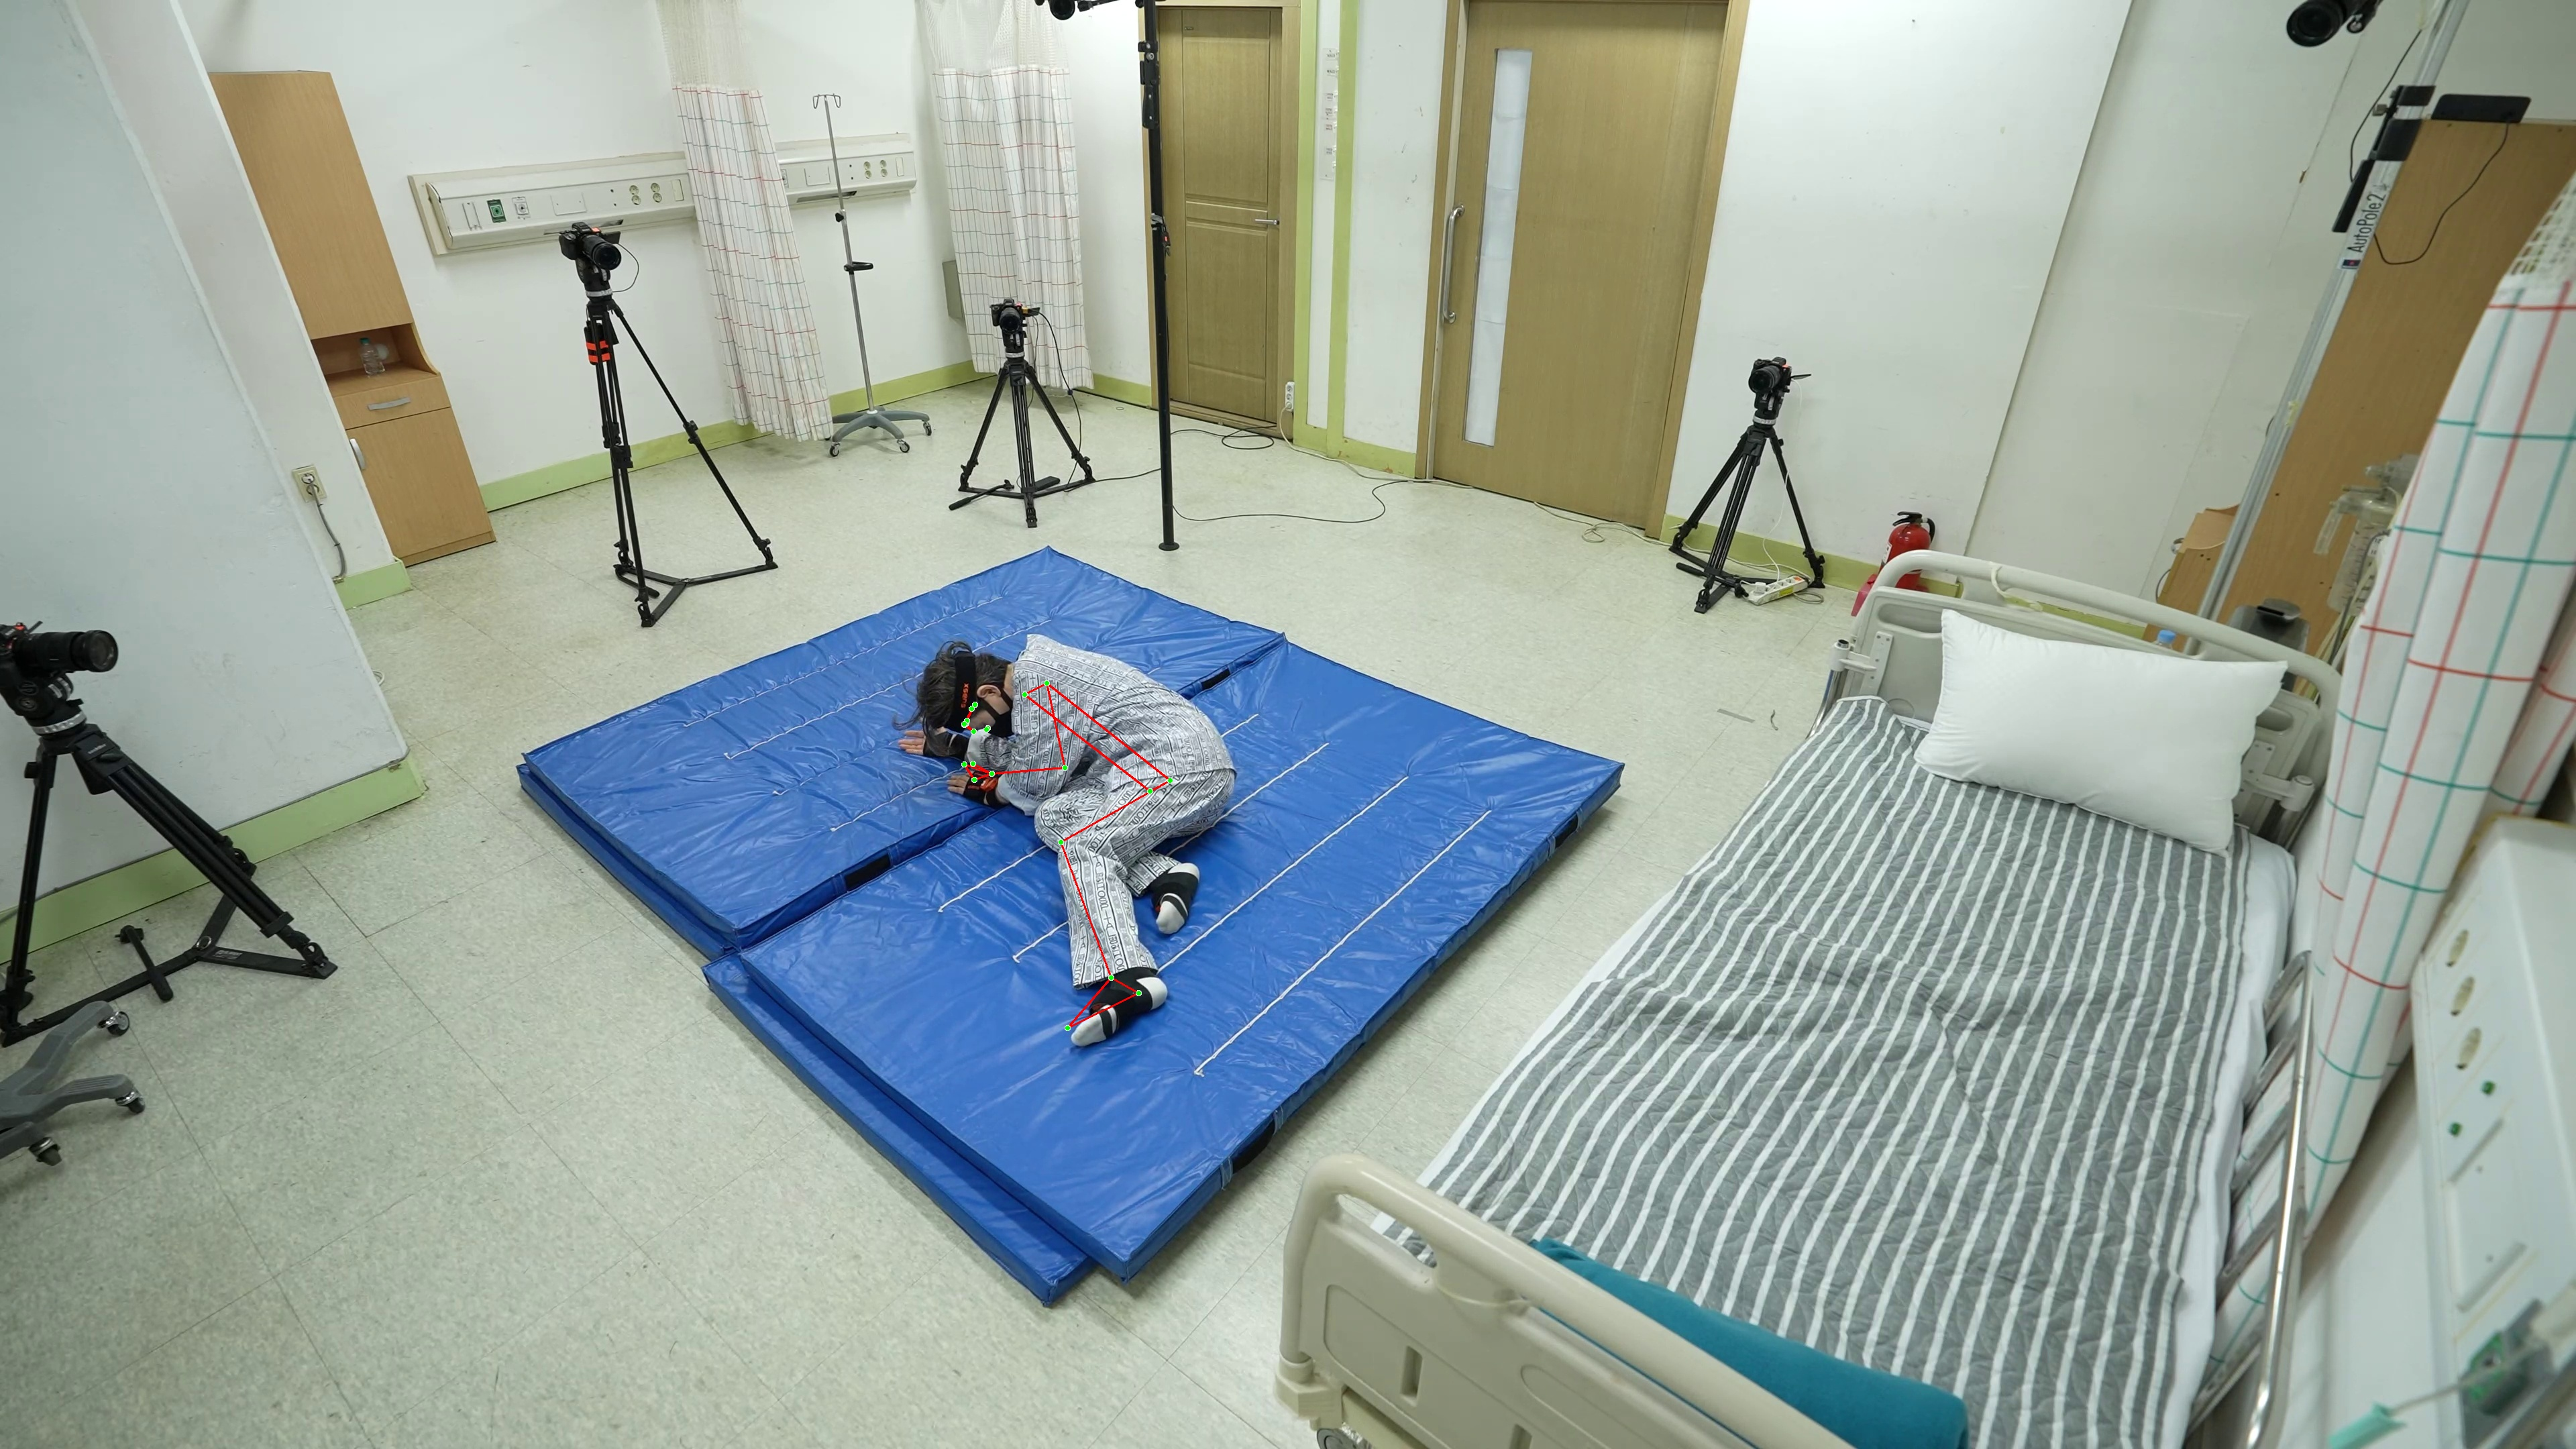

In [27]:
from IPython.display import Image, display

# 이미지 경로
image_path = images[12]

# 직접 출력
display(Image(image_path))

In [ ]:
# 낙상 이미지 폴더에서 좌표 추출출
import glob
import pandas as pd
from pathlib import Path

# 이미지 폴더 경로
image_folder = './이미지_스켈레톤_낙상'
images = glob.glob(f'{image_folder}/*.jpg') + glob.glob(f'{image_folder}/*.JPG')

# 결과를 저장할 리스트
results = []

# 각 이미지에 대해 관절 좌표 추출
num = 0
for img_path in images:
    joints = extract_body_joints(img_path)
    
    # 관절 좌표가 없으면 건너뜀
    if joints is not None:
        result = {'이미지명': Path(img_path).name}
        
        for joint_name, coords in joints.items():
            result[f'{joint_name}_x'] = coords[0]
            result[f'{joint_name}_y'] = coords[1]
            result[f'{joint_name}_z'] = coords[2]
        
        results.append(result)
    
    num += 1

    if num % 10 == 0:
        print(f'{num}번째 이미지 처리 완료')

# DataFrame 생성 및 CSV 저장
df = pd.DataFrame(results)
df.to_csv('관절좌표_낙상.csv', index=False, encoding='utf-8-sig')

print(f"완료 {len(results)}개 이미지 처리 완료")
# 왜 이미지 처리가 940까지 도는지는 모르겠..

10번째 이미지 처리 완료
20번째 이미지 처리 완료
30번째 이미지 처리 완료
40번째 이미지 처리 완료
50번째 이미지 처리 완료
60번째 이미지 처리 완료
70번째 이미지 처리 완료
80번째 이미지 처리 완료
90번째 이미지 처리 완료
100번째 이미지 처리 완료
110번째 이미지 처리 완료
120번째 이미지 처리 완료
130번째 이미지 처리 완료
140번째 이미지 처리 완료
150번째 이미지 처리 완료
160번째 이미지 처리 완료
170번째 이미지 처리 완료
180번째 이미지 처리 완료
190번째 이미지 처리 완료
200번째 이미지 처리 완료
210번째 이미지 처리 완료
220번째 이미지 처리 완료
230번째 이미지 처리 완료
240번째 이미지 처리 완료
250번째 이미지 처리 완료
260번째 이미지 처리 완료
270번째 이미지 처리 완료
280번째 이미지 처리 완료
290번째 이미지 처리 완료
300번째 이미지 처리 완료
310번째 이미지 처리 완료
320번째 이미지 처리 완료
330번째 이미지 처리 완료
340번째 이미지 처리 완료
350번째 이미지 처리 완료
360번째 이미지 처리 완료
370번째 이미지 처리 완료
380번째 이미지 처리 완료
390번째 이미지 처리 완료
400번째 이미지 처리 완료
410번째 이미지 처리 완료
420번째 이미지 처리 완료
430번째 이미지 처리 완료
440번째 이미지 처리 완료
450번째 이미지 처리 완료
460번째 이미지 처리 완료
470번째 이미지 처리 완료
480번째 이미지 처리 완료
490번째 이미지 처리 완료
500번째 이미지 처리 완료
510번째 이미지 처리 완료
520번째 이미지 처리 완료
530번째 이미지 처리 완료
540번째 이미지 처리 완료
550번째 이미지 처리 완료
560번째 이미지 처리 완료
570번째 이미지 처리 완료
580번째 이미지 처리 완료
590번째 이미지 처리 완료
600번째 이미지 처리 완료
610번째 이미지 처리 완료
620번째 이미지 처리 완료
630번째 이미지 처리 완료
6

In [69]:
df_fall = pd.read_csv('관절좌표_낙상.csv')
df_fall

,이미지명,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,...,heel_left_z,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z
0,skeleton_00012_H_A_SY_C2_00012_H_A_SY_C2_I008.jpg,0.435763,0.393353,-0.060513,0.450899,0.409974,-0.195518,0.456286,0.445746,-0.005041,...,0.255843,0.502223,0.599672,0.118176,0.525518,0.547398,0.253216,0.526329,0.578757,0.107529
1,skeleton_00038_H_A_SY_C2_00038_H_A_SY_C2_I007.jpg,0.428752,0.488106,-0.032260,0.422999,0.499246,-0.012904,0.434660,0.496799,-0.054531,...,0.000496,0.427503,0.529577,0.005199,0.431742,0.534946,-0.005695,0.423142,0.535916,-0.001194
2,skeleton_00045_H_A_SY_C2_00045_H_A_SY_C2_I005.jpg,0.482004,0.419709,0.060772,0.509916,0.434932,0.058366,0.459979,0.455557,0.042719,...,-0.029522,0.474550,0.587873,-0.073807,0.451210,0.633047,-0.029677,0.466626,0.615715,-0.081620
3,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I007.jpg,0.390403,0.484546,-0.025941,0.386528,0.490029,0.018594,0.387148,0.487611,-0.037775,...,-0.012477,0.371070,0.527552,0.014389,0.366596,0.515933,-0.019382,0.366914,0.521486,0.009456
4,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I008.jpg,0.406541,0.477018,-0.074663,0.388841,0.499071,0.041201,0.417709,0.528848,-0.101417,...,-0.133115,0.450890,0.618692,0.190732,0.417926,0.711178,-0.163919,0.446416,0.650520,0.190693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I006.jpg,0.658612,0.559319,-0.025051,0.686785,0.641530,-0.080639,0.630734,0.597264,0.069803,...,0.375532,0.610697,0.703690,0.386824,0.512791,0.655523,0.383919,0.619665,0.692167,0.414513
562,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I007.jpg,0.623185,0.532911,-0.042664,0.669849,0.588140,-0.026654,0.600122,0.590547,0.050837,...,0.223450,0.557155,0.699142,0.342970,0.497929,0.657761,0.256830,0.552110,0.682025,0.373461
563,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I008.jpg,0.612862,0.530144,-0.031358,0.645332,0.592722,-0.031379,0.609599,0.526043,0.060887,...,0.132898,0.548911,0.689197,0.228931,0.492758,0.666902,0.161967,0.537463,0.693433,0.256255
564,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I009.jpg,0.624782,0.534932,-0.000443,0.663318,0.595238,-0.043300,0.607025,0.561458,0.116439,...,0.286274,0.554590,0.687822,0.312206,0.502007,0.661231,0.313678,0.551459,0.684704,0.348078


In [75]:
# 라벨 달아주기
df_fall['label'] = 1
df_fall

,이미지명,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,...,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z,label
0,skeleton_00012_H_A_SY_C2_00012_H_A_SY_C2_I008.jpg,0.435763,0.393353,-0.060513,0.450899,0.409974,-0.195518,0.456286,0.445746,-0.005041,...,0.502223,0.599672,0.118176,0.525518,0.547398,0.253216,0.526329,0.578757,0.107529,1
1,skeleton_00038_H_A_SY_C2_00038_H_A_SY_C2_I007.jpg,0.428752,0.488106,-0.032260,0.422999,0.499246,-0.012904,0.434660,0.496799,-0.054531,...,0.427503,0.529577,0.005199,0.431742,0.534946,-0.005695,0.423142,0.535916,-0.001194,1
2,skeleton_00045_H_A_SY_C2_00045_H_A_SY_C2_I005.jpg,0.482004,0.419709,0.060772,0.509916,0.434932,0.058366,0.459979,0.455557,0.042719,...,0.474550,0.587873,-0.073807,0.451210,0.633047,-0.029677,0.466626,0.615715,-0.081620,1
3,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I007.jpg,0.390403,0.484546,-0.025941,0.386528,0.490029,0.018594,0.387148,0.487611,-0.037775,...,0.371070,0.527552,0.014389,0.366596,0.515933,-0.019382,0.366914,0.521486,0.009456,1
4,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I008.jpg,0.406541,0.477018,-0.074663,0.388841,0.499071,0.041201,0.417709,0.528848,-0.101417,...,0.450890,0.618692,0.190732,0.417926,0.711178,-0.163919,0.446416,0.650520,0.190693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I006.jpg,0.658612,0.559319,-0.025051,0.686785,0.641530,-0.080639,0.630734,0.597264,0.069803,...,0.610697,0.703690,0.386824,0.512791,0.655523,0.383919,0.619665,0.692167,0.414513,1
562,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I007.jpg,0.623185,0.532911,-0.042664,0.669849,0.588140,-0.026654,0.600122,0.590547,0.050837,...,0.557155,0.699142,0.342970,0.497929,0.657761,0.256830,0.552110,0.682025,0.373461,1
563,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I008.jpg,0.612862,0.530144,-0.031358,0.645332,0.592722,-0.031379,0.609599,0.526043,0.060887,...,0.548911,0.689197,0.228931,0.492758,0.666902,0.161967,0.537463,0.693433,0.256255,1
564,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I009.jpg,0.624782,0.534932,-0.000443,0.663318,0.595238,-0.043300,0.607025,0.561458,0.116439,...,0.554590,0.687822,0.312206,0.502007,0.661231,0.313678,0.551459,0.684704,0.348078,1


In [ ]:
# 정정상 이미지 폴더에서 좌표 추출출
import glob
import pandas as pd
from pathlib import Path

# 이미지 폴더 경로
image_folder = './이미지_스켈레톤_정상'
images = glob.glob(f'{image_folder}/*.jpg') + glob.glob(f'{image_folder}/*.JPG')

# 결과를 저장할 리스트
results = []

# 각 이미지에 대해 관절 좌표 추출
num = 0
for img_path in images:
    joints = extract_body_joints(img_path)
    
    # 관절 좌표가 없으면 건너뜀
    if joints is not None:
        result = {'이미지명': Path(img_path).name}
        
        for joint_name, coords in joints.items():
            result[f'{joint_name}_x'] = coords[0]
            result[f'{joint_name}_y'] = coords[1]
            result[f'{joint_name}_z'] = coords[2]
        
        results.append(result)
    
    num += 1

    if num % 10 == 0:
        print(f'{num}번째 이미지 처리 완료')

# DataFrame 생성 및 CSV 저장
df = pd.DataFrame(results)
df.to_csv('관절좌표_정상.csv', index=False, encoding='utf-8-sig')

print(f"완료 {len(results)}개 이미지 처리 완료")

10번째 이미지 처리 완료
20번째 이미지 처리 완료
30번째 이미지 처리 완료
40번째 이미지 처리 완료
50번째 이미지 처리 완료
60번째 이미지 처리 완료
70번째 이미지 처리 완료
80번째 이미지 처리 완료
90번째 이미지 처리 완료
100번째 이미지 처리 완료
110번째 이미지 처리 완료
120번째 이미지 처리 완료
130번째 이미지 처리 완료
140번째 이미지 처리 완료
150번째 이미지 처리 완료
160번째 이미지 처리 완료
170번째 이미지 처리 완료
180번째 이미지 처리 완료
190번째 이미지 처리 완료
200번째 이미지 처리 완료
210번째 이미지 처리 완료
220번째 이미지 처리 완료
230번째 이미지 처리 완료
240번째 이미지 처리 완료
250번째 이미지 처리 완료
260번째 이미지 처리 완료
270번째 이미지 처리 완료
280번째 이미지 처리 완료
290번째 이미지 처리 완료
300번째 이미지 처리 완료
310번째 이미지 처리 완료
320번째 이미지 처리 완료
330번째 이미지 처리 완료
340번째 이미지 처리 완료
350번째 이미지 처리 완료
360번째 이미지 처리 완료
370번째 이미지 처리 완료
380번째 이미지 처리 완료
390번째 이미지 처리 완료
400번째 이미지 처리 완료
410번째 이미지 처리 완료
420번째 이미지 처리 완료
430번째 이미지 처리 완료
440번째 이미지 처리 완료
450번째 이미지 처리 완료
460번째 이미지 처리 완료
470번째 이미지 처리 완료
480번째 이미지 처리 완료
490번째 이미지 처리 완료
500번째 이미지 처리 완료
510번째 이미지 처리 완료
520번째 이미지 처리 완료
530번째 이미지 처리 완료
540번째 이미지 처리 완료
550번째 이미지 처리 완료
560번째 이미지 처리 완료
570번째 이미지 처리 완료
580번째 이미지 처리 완료
590번째 이미지 처리 완료
600번째 이미지 처리 완료
610번째 이미지 처리 완료
620번째 이미지 처리 완료
630번째 이미지 처리 완료
6

In [ ]:
df_unfall = pd.read_csv('관절좌표_정상.csv')
df_unfall

,이미지명,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,...,heel_left_z,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z
0,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I001.jpg,0.753593,0.350214,-0.206163,0.768779,0.339207,0.048212,0.740934,0.463241,-0.208642,...,-0.040639,0.728246,0.666512,0.205293,0.612482,0.682906,-0.041142,0.698226,0.680272,0.207683
1,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I002.jpg,0.824804,0.386576,-0.164096,0.811210,0.378062,0.081821,0.771267,0.483451,-0.181919,...,-0.067582,0.621821,0.731226,0.102460,0.571194,0.730976,-0.092529,0.585664,0.717826,0.066912
2,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I003.jpg,0.701747,0.349652,-0.104326,0.724393,0.307809,0.039116,0.712974,0.431624,-0.103629,...,0.230317,0.747322,0.515102,0.322474,0.717352,0.503901,0.273515,0.727316,0.519158,0.348404
3,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I004.jpg,0.690435,0.280365,-0.181050,0.701052,0.268436,0.102711,0.691867,0.390491,-0.210653,...,-0.073233,0.646909,0.725365,0.177754,0.586024,0.745431,-0.120351,0.606127,0.727946,0.146702
4,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I005.jpg,0.578544,0.325816,-0.083011,0.633805,0.301923,-0.039444,0.562720,0.391073,-0.016461,...,0.250748,0.623438,0.579355,0.347329,0.605597,0.588414,0.269182,0.603018,0.578942,0.366740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,skeleton_02928_H_B_SY_C2_02928_H_B_SY_C2_I010.jpg,0.567777,0.484640,0.021030,0.607460,0.532388,-0.082893,0.567074,0.538375,0.031246,...,0.371019,0.578834,0.598291,0.256590,0.598809,0.583535,0.374168,0.596767,0.583269,0.265280
896,skeleton_02931_H_B_SY_C2_02931_H_B_SY_C2_I004.jpg,0.599599,0.293536,-0.134458,0.582887,0.368840,-0.287569,0.610596,0.278974,0.001606,...,0.420025,0.540648,0.642126,0.304908,0.586898,0.619132,0.402917,0.559982,0.645878,0.271286
897,skeleton_02931_H_B_SY_C2_02931_H_B_SY_C2_I005.jpg,0.661029,0.516276,0.051556,0.675380,0.590698,-0.184570,0.661620,0.598287,0.106166,...,0.348911,0.607483,0.698672,0.147586,0.609407,0.709925,0.373045,0.624524,0.720424,0.188575
898,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I003.jpg,0.580368,0.358779,0.005085,0.544095,0.322713,0.007140,0.577261,0.435600,0.007482,...,0.227979,0.465015,0.649419,-0.061722,0.523720,0.636288,0.186565,0.464250,0.653337,-0.140694


In [76]:
df_unfall['label'] = 0
df_unfall.head()

,이미지명,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,...,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z,label
0,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I001.jpg,0.753593,0.350214,-0.206163,0.768779,0.339207,0.048212,0.740934,0.463241,-0.208642,...,0.728246,0.666512,0.205293,0.612482,0.682906,-0.041142,0.698226,0.680272,0.207683,0
1,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I002.jpg,0.824804,0.386576,-0.164096,0.811210,0.378062,0.081821,0.771267,0.483451,-0.181919,...,0.621821,0.731226,0.102460,0.571194,0.730976,-0.092529,0.585664,0.717826,0.066912,0
2,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I003.jpg,0.701747,0.349652,-0.104326,0.724393,0.307809,0.039116,0.712974,0.431624,-0.103629,...,0.747322,0.515102,0.322474,0.717352,0.503901,0.273515,0.727316,0.519158,0.348404,0
3,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I004.jpg,0.690435,0.280365,-0.181050,0.701052,0.268436,0.102711,0.691867,0.390491,-0.210653,...,0.646909,0.725365,0.177754,0.586024,0.745431,-0.120351,0.606127,0.727946,0.146702,0
4,skeleton_00004_H_A_SY_C2_00004_H_A_SY_C2_I005.jpg,0.578544,0.325816,-0.083011,0.633805,0.301923,-0.039444,0.562720,0.391073,-0.016461,...,0.623438,0.579355,0.347329,0.605597,0.588414,0.269182,0.603018,0.578942,0.366740,0


In [77]:
df = pd.concat([df_fall, df_unfall], axis=0)
len(df)

1466

In [82]:
df

,이미지명,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,...,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z,label
0,skeleton_00012_H_A_SY_C2_00012_H_A_SY_C2_I008.jpg,0.435763,0.393353,-0.060513,0.450899,0.409974,-0.195518,0.456286,0.445746,-0.005041,...,0.502223,0.599672,0.118176,0.525518,0.547398,0.253216,0.526329,0.578757,0.107529,1
1,skeleton_00038_H_A_SY_C2_00038_H_A_SY_C2_I007.jpg,0.428752,0.488106,-0.032260,0.422999,0.499246,-0.012904,0.434660,0.496799,-0.054531,...,0.427503,0.529577,0.005199,0.431742,0.534946,-0.005695,0.423142,0.535916,-0.001194,1
2,skeleton_00045_H_A_SY_C2_00045_H_A_SY_C2_I005.jpg,0.482004,0.419709,0.060772,0.509916,0.434932,0.058366,0.459979,0.455557,0.042719,...,0.474550,0.587873,-0.073807,0.451210,0.633047,-0.029677,0.466626,0.615715,-0.081620,1
3,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I007.jpg,0.390403,0.484546,-0.025941,0.386528,0.490029,0.018594,0.387148,0.487611,-0.037775,...,0.371070,0.527552,0.014389,0.366596,0.515933,-0.019382,0.366914,0.521486,0.009456,1
4,skeleton_00049_H_A_SY_C2_00049_H_A_SY_C2_I008.jpg,0.406541,0.477018,-0.074663,0.388841,0.499071,0.041201,0.417709,0.528848,-0.101417,...,0.450890,0.618692,0.190732,0.417926,0.711178,-0.163919,0.446416,0.650520,0.190693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,skeleton_02928_H_B_SY_C2_02928_H_B_SY_C2_I010.jpg,0.567777,0.484640,0.021030,0.607460,0.532388,-0.082893,0.567074,0.538375,0.031246,...,0.578834,0.598291,0.256590,0.598809,0.583535,0.374168,0.596767,0.583269,0.265280,0
896,skeleton_02931_H_B_SY_C2_02931_H_B_SY_C2_I004.jpg,0.599599,0.293536,-0.134458,0.582887,0.368840,-0.287569,0.610596,0.278974,0.001606,...,0.540648,0.642126,0.304908,0.586898,0.619132,0.402917,0.559982,0.645878,0.271286,0
897,skeleton_02931_H_B_SY_C2_02931_H_B_SY_C2_I005.jpg,0.661029,0.516276,0.051556,0.675380,0.590698,-0.184570,0.661620,0.598287,0.106166,...,0.607483,0.698672,0.147586,0.609407,0.709925,0.373045,0.624524,0.720424,0.188575,0
898,skeleton_02935_H_B_SY_C2_02935_H_B_SY_C2_I003.jpg,0.580368,0.358779,0.005085,0.544095,0.322713,0.007140,0.577261,0.435600,0.007482,...,0.465015,0.649419,-0.061722,0.523720,0.636288,0.186565,0.464250,0.653337,-0.140694,0


---

학습 진행해보기

In [86]:
df.drop(columns=['이미지명'], inplace=True)

In [87]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = True, stratify=df['label'])

X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_val = test_df.drop(columns=['label'])
y_val = test_df['label']

In [88]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1172, 48), (1172,), (294, 48), (294,))

In [89]:
X_train

,shoulder_left_x,shoulder_left_y,shoulder_left_z,shoulder_right_x,shoulder_right_y,shoulder_right_z,elbow_left_x,elbow_left_y,elbow_left_z,elbow_right_x,...,heel_left_z,heel_right_x,heel_right_y,heel_right_z,toe_left_x,toe_left_y,toe_left_z,toe_right_x,toe_right_y,toe_right_z
255,0.468223,0.222026,0.027680,0.504153,0.215010,-0.180412,0.473349,0.257662,0.175355,0.552141,...,0.394368,0.505614,0.655966,0.256705,0.522919,0.621535,0.393544,0.534036,0.641672,0.241846
468,0.518860,0.491594,-0.051235,0.559753,0.434140,-0.068151,0.512409,0.536442,0.035955,0.590561,...,0.368179,0.645111,0.496406,0.337034,0.602518,0.480552,0.389761,0.641289,0.473727,0.353786
208,0.558240,0.395608,-0.121659,0.589759,0.466916,-0.124216,0.563251,0.391294,-0.049213,0.598419,...,0.299741,0.590926,0.476364,0.297617,0.601342,0.431628,0.279688,0.600723,0.450705,0.276815
605,0.700203,0.431125,-0.138444,0.683060,0.416931,0.031880,0.687142,0.532995,-0.162415,0.661988,...,-0.078466,0.650226,0.736699,0.091621,0.624065,0.783506,-0.119406,0.626595,0.749361,0.075614
676,0.500129,0.255684,-0.104062,0.547735,0.213750,0.026046,0.501269,0.353666,-0.122862,0.569921,...,0.147272,0.591081,0.610023,0.229405,0.531463,0.625594,0.150134,0.579755,0.600325,0.234534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.827050,0.498157,-0.107637,0.862086,0.493250,-0.063448,0.816750,0.588539,-0.057017,0.869586,...,0.232234,0.823728,0.807453,0.278267,0.781144,0.808933,0.229419,0.813866,0.803457,0.276028
354,0.508427,0.317559,0.031311,0.543700,0.369663,0.037278,0.471089,0.340097,0.000062,0.516881,...,0.020630,0.438648,0.427272,0.014833,0.419906,0.439355,0.023229,0.415432,0.436730,0.011969
305,0.605475,0.344934,-0.040319,0.627337,0.431983,-0.190700,0.627653,0.363749,0.104221,0.655341,...,0.464109,0.603850,0.641577,0.253858,0.594457,0.587202,0.476398,0.628201,0.659327,0.257608
425,0.444331,0.308991,0.101526,0.406353,0.314471,0.005809,0.444835,0.401314,0.120579,0.403591,...,0.055326,0.530570,0.594439,0.060974,0.568054,0.578936,0.056153,0.546694,0.614320,0.070151


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [92]:
pred = svc.predict(X_val)

print(classification_report(y_val, pred))
print(confusion_matrix(y_val, pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       180
           1       0.82      0.85      0.84       114

    accuracy                           0.87       294
   macro avg       0.86      0.87      0.86       294
weighted avg       0.87      0.87      0.87       294

[[159  21]
 [ 17  97]]


In [98]:
svc.predict(X_val.iloc[0, :].values.reshape(1, -1))

c:\Users\ASUS\anaconda3\envs\opencv38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

스케일링 후 적용용

In [100]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

svc.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [101]:
scaled_pred = svc.predict(X_val_scaled)

print(classification_report(y_val, scaled_pred))
print(confusion_matrix(y_val, scaled_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       180
           1       0.80      0.88      0.84       114

    accuracy                           0.87       294
   macro avg       0.86      0.87      0.86       294
weighted avg       0.87      0.87      0.87       294

[[155  25]
 [ 14 100]]
